# What Clinical Conditions Predict PCOS Diagnosis?

This analysis uses a random forest classification model to examine the clinical factors that best predict a PCOS diagnosis. 

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

## Data Cleaning

In [192]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel("PCOS_data_without_infertility.xlsx", sheet_name="Full_new")

# Replace non-numeric placeholders with NaN
df = df.replace(["#NAME?", "NA", "N/A", " ", ""], np.nan)

# Inspect the original columns
print("Original columns:")
print(df.columns.tolist())

# Clean column names: strip spaces, lowercase, replace special chars
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r'\s+', '_', regex=True)       
      .str.replace(r'\(|\)', '', regex=True)     
      .str.replace(r'\.', '_', regex=True)       
      .str.replace(r'-', '_', regex=True)
      .str.replace(r'/', '_', regex=True)
)

print("\nCleaned columns:")
print(df.columns.tolist())

# Define the feature and target columns
feature_cols = [
    'age_yrs',
    'weight_gainy_n',
    'hair_growthy_n',
    'skin_darkening_y_n',
    'hair_lossy_n',
    'pimplesy_n',
    'fast_food_y_n',        
    'reg_exercisey_n',
    'amhng_ml',
    'lhmiu_ml',
    'fshmiu_ml',
    'prlng_ml',
    'tsh_miu_l',
    'prgng_ml'
]

target_col = 'pcos_y_n'

# Check which columns are missing from dataset
missing_cols = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing_cols:
    print("\nColumns missing from dataset:", missing_cols)
else:
    print("\nAll columns found")

# Subset the dataframe with available columns
df_model = df[[c for c in feature_cols + [target_col] if c in df.columns]].copy()

# Convert numeric columns
numeric_cols = ['age_yrs', 'fshmiu_ml', 'lhmiu_ml', 'amhng_ml', 'prlng_ml', 'tsh_miu_l', 'prgng_ml']
for col in numeric_cols:
    if col in df_model.columns:
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Ensure binary columns are integers
binary_cols = [c for c in feature_cols if c not in numeric_cols] + [target_col]
for col in binary_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype('Int64')

# Drop rows with missing values
df_clean = df_model.dropna().reset_index(drop=True)

# Split into X and y
X = df_clean[[c for c in feature_cols if c in df_clean.columns]]
y = df_clean[target_col]

print("\nFinal cleaned dataset shape:", X.shape)
X.head()


Original columns:
['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Unnamed: 44']

Cleaned columns:
['sl__no', 'patient_file_no_', 'pcos_y_n', 'age_yrs', 'weight_kg', 'heightcm', 'bmi', 'blood_group', 'pulse_ratebpm', 'rr_breaths_min', 'hbg_dl', 'cycler_i', 'cycle_le

,age_yrs,weight_gainy_n,hair_growthy_n,skin_darkening_y_n,hair_lossy_n,pimplesy_n,fast_food_y_n,reg_exercisey_n,amhng_ml,lhmiu_ml,fshmiu_ml,prlng_ml,tsh_miu_l,prgng_ml
0,28,0,0,0,0,0,1,0,2.07,3.68,7.95,45.16,0.68,0.57
1,36,0,0,0,0,0,0,0,1.53,1.09,6.73,20.09,3.16,0.97
2,33,0,0,0,1,1,1,0,6.63,0.88,5.54,10.52,2.54,0.36
3,37,0,0,0,0,0,0,0,1.22,2.36,8.06,36.90,16.41,0.36
4,25,0,0,0,1,0,0,0,2.26,0.90,3.98,30.09,3.57,0.38


## Random Forest Model

In [193]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train random forest model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model Evaluation

Classification Report:

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87        73
         1.0       0.71      0.77      0.74        35

    accuracy                           0.82       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.83      0.82      0.83       108



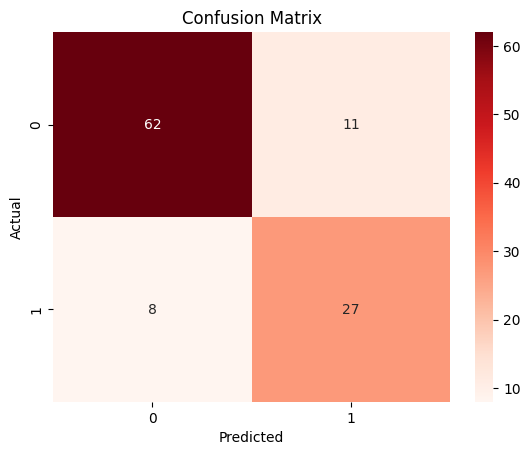

In [194]:
# Evaluate model
y_pred = rf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Feature Importance 

               Feature  Importance
3   skin_darkening_y_n    0.156102
1       weight_gainy_n    0.147155
2       hair_growthy_n    0.138245
8             amhng_ml    0.111700
6        fast_food_y_n    0.067508
9             lhmiu_ml    0.060194
0              age_yrs    0.055919
10           fshmiu_ml    0.050058
12           tsh_miu_l    0.049306
5           pimplesy_n    0.048553
11            prlng_ml    0.046581
13            prgng_ml    0.038332
4         hair_lossy_n    0.017610
7      reg_exercisey_n    0.012738


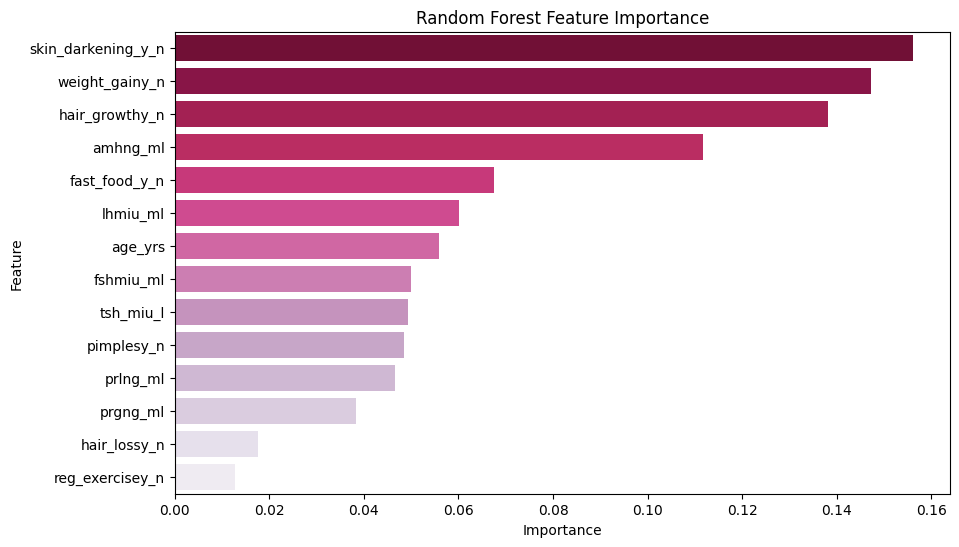

In [195]:
# Feature importance
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


print(feat_importance)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, hue='Feature', palette='PuRd_r', legend=False)
plt.title('Random Forest Feature Importance')
plt.show()


### Top Feature Distribution

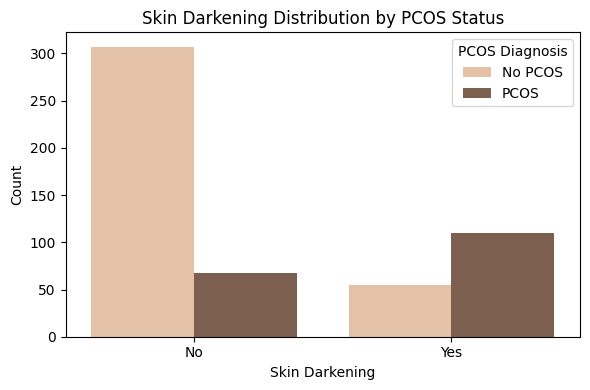

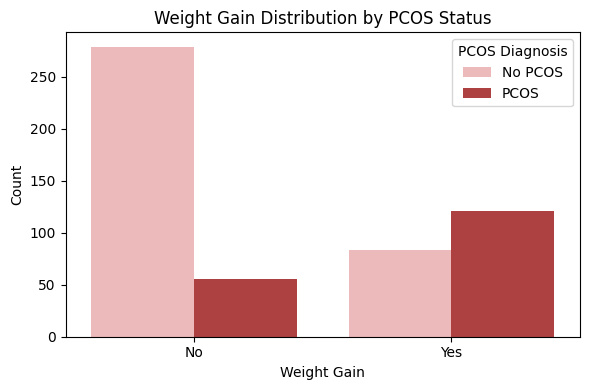

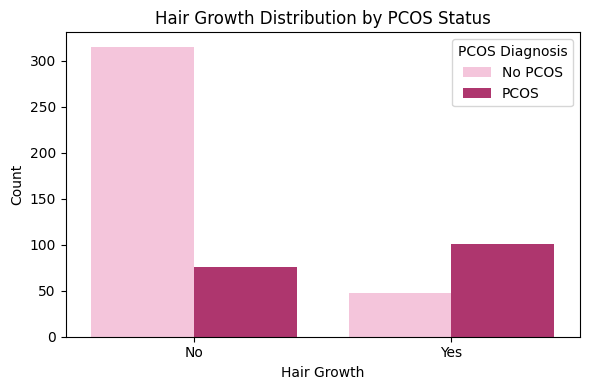

In [196]:
# Custom mapping 
label_map = {0: "No", 1: "Yes"}

# Custom titles for x-axis based on feature names
pretty_name = {
    "skin_darkening_y_n": "Skin Darkening",
    "weight_gainy_n": "Weight Gain",
    "hair_growthy_n": "Hair Growth",
    "pimplesy_n": "Pimples",
    "fast_food_y_n": "Fast Food Consumption",
    "hair_lossy_n": "Hair Loss",
    "reg_exercisey_n": "Regular Exercise",
}

# Top 3 features (adjust palette per feature)
top_features = [f for f in feat_importance['Feature'].head(3).tolist() if f in df_clean.columns]
palettes = [
    ["#EDC19D", "#845C49"],  # Skin Darkening
    ["#F5B1B1", "#BF2E2E"],  # Weight Gain
    ["#FCBDDA", "#C2226D"],  # Hair Growth
]

for i, f in enumerate(top_features):
    if df_clean[f].nunique() == 2:
        plt.figure(figsize=(6,4))
        ax = sns.countplot(
            x=f,
            hue=target_col,
            data=df_clean,
            palette=palettes[i]
        )

        # Correct way to relabel ticks
        ax.set_xticks([0,1])
        ax.set_xticklabels([label_map[0], label_map[1]])

        # Set axis title
        x_label = pretty_name.get(f, f)
        ax.set_xlabel(x_label)
        ax.set_ylabel("Count")

        # Update legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ["No PCOS", "PCOS"], title="PCOS Diagnosis")

        plt.title(f"{x_label} Distribution by PCOS Status")
        plt.tight_layout()
        plt.show()



### Misclassification

In [197]:
# Total patients in test set
print(y_test.shape)
# Misclassified patients
print((y_test != y_pred).sum())


(108,)
19


In [198]:
# Create a results DataFrame
results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = y_pred

# Filter misclassified samples
misclassified = results[results['actual'] != results['predicted']]


print("Total misclassified samples:", len(misclassified))

# Get 5 samples
print(f"\n5 misclassified samples:")
misclassified_samples = misclassified.head(5)

# Display important information
for idx, row in misclassified_samples.iterrows():
    print(f"\n--- Misclassified Sample {idx} ---")
    print("\nKey feature values:")
    print(f"Actual PCOS diagnosis: {row['actual']}")
    print(f"Predicted: {row['predicted']}")
    print(row[feature_cols]) 


Total misclassified samples: 19

5 misclassified samples:

--- Misclassified Sample 442 ---

Key feature values:
Actual PCOS diagnosis: 1
Predicted: 0.0
age_yrs                 27
weight_gainy_n           0
hair_growthy_n           0
skin_darkening_y_n       0
hair_lossy_n             0
pimplesy_n               0
fast_food_y_n            1
reg_exercisey_n          1
amhng_ml              16.9
lhmiu_ml              2.23
fshmiu_ml             4.97
prlng_ml              9.12
tsh_miu_l             1.94
prgng_ml              0.25
Name: 442, dtype: object

--- Misclassified Sample 473 ---

Key feature values:
Actual PCOS diagnosis: 1
Predicted: 0.0
age_yrs                  31
weight_gainy_n            0
hair_growthy_n            0
skin_darkening_y_n        1
hair_lossy_n              0
pimplesy_n                0
fast_food_y_n             0
reg_exercisey_n           1
amhng_ml               6.09
lhmiu_ml               7.48
fshmiu_ml              6.53
prlng_ml              14.79
tsh_miu_l    

Misclassified Samples

In [199]:
# Define the misclassified samples table

pd.set_option('display.max_colwidth', None)   
pd.set_option('display.width', 1000)     

misclassified_data = {
    "Sample": [442, 473, 462, 233, 275],
    "Actual PCOS Diagnosis": [1, 1, 1, 0, 1],
    "Predicted PCOS Diagnosis": [0, 0, 0, 1, 0],
    "Observations": [
        "Low LH and PRL relative to class average. High AMH. No visible symptoms (hair growth, skin darkening, weight gain)",
        "Moderate AMH. Slightly elevated LH/FSH. Only skin darkening present. Most other symptoms absent",
        "Very low AMH. PRL extremely high compared to class average. Minimal clinical symptoms",
        "Hair growth, skin darkening, and pimples present. Hormonal markers close to class 0 average, but symptoms mimic PCOS",
        "Low AMH, moderately elevated LH/FSH. Some symptoms absent. Age slightly higher than class 1 average"
    ]
}

# Create DataFrame
misclassified_df = pd.DataFrame(misclassified_data)

# Display the table

# Display without index 
from IPython.display import display, HTML
display(HTML(misclassified_df.to_html(index=False)))


Sample,Actual PCOS Diagnosis,Predicted PCOS Diagnosis,Observations
442,1,0,"Low LH and PRL relative to class average. High AMH. No visible symptoms (hair growth, skin darkening, weight gain)"
473,1,0,Moderate AMH. Slightly elevated LH/FSH. Only skin darkening present. Most other symptoms absent
462,1,0,Very low AMH. PRL extremely high compared to class average. Minimal clinical symptoms
233,0,1,"Hair growth, skin darkening, and pimples present. Hormonal markers close to class 0 average, but symptoms mimic PCOS"
275,1,0,"Low AMH, moderately elevated LH/FSH. Some symptoms absent. Age slightly higher than class 1 average"


Compare misclassified samples to class averages

In [200]:
print("Misclassified samples compared to class averages:")

class_means = df_clean.groupby('pcos_y_n')[feature_cols].mean()

for idx, row in misclassified_samples.iterrows():
    print(f"\n--- Misclassified Sample {idx} ---")
    print(f"Actual: {row['actual']} | Predicted: {row['predicted']}")
    
    diffs = row[feature_cols] - class_means.loc[row['actual']]
    print("\nDifference from average of true class:")
    print(diffs.sort_values(key=lambda x: abs(x), ascending=False).head(5))


Misclassified samples compared to class averages:

--- Misclassified Sample 442 ---
Actual: 1 | Predicted: 0.0

Difference from average of true class:
prlng_ml    -15.311808
lhmiu_ml    -12.172328
amhng_ml      9.055367
age_yrs      -3.124294
tsh_miu_l    -0.986723
dtype: object

--- Misclassified Sample 473 ---
Actual: 1 | Predicted: 0.0

Difference from average of true class:
prlng_ml    -9.641808
lhmiu_ml    -6.922328
amhng_ml    -1.754633
fshmiu_ml    1.355407
age_yrs      0.875706
dtype: object

--- Misclassified Sample 462 ---
Actual: 1 | Predicted: 0.0

Difference from average of true class:
prlng_ml     35.968192
lhmiu_ml    -12.102328
amhng_ml     -6.994633
age_yrs       3.875706
tsh_miu_l     3.733277
dtype: object

--- Misclassified Sample 233 ---
Actual: 0 | Predicted: 1.0

Difference from average of true class:
fshmiu_ml   -17.425381
age_yrs      -5.066298
prlng_ml      4.943978
lhmiu_ml     -2.524514
amhng_ml     -1.039483
dtype: object

--- Misclassified Sample 275 ---
A